## IMPORTS

In [29]:
import tifffile
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import SAM
from pathlib import Path
import torch
from codecarbon import EmissionsTracker
from datetime import datetime
import csv

## PARAMETRES

In [30]:

GRID_STRIDE   = 64                   # densité des points
POINTS_PER_CALL = 30                # taille des chunks envoyés à SAM
MIN_AREA      = 300                  # aire min d’un masque (en pixels)
CONF_THR      = 0.35                 #  seuil min confiance de SAM
DEDUP_IOU_THR = 0.90                 # seuil de dé-duplication
MIN_MASK_REGION_AREA = 200
IMAGE_3D_PATH = "../data/Romane_Martin_urne_sature_10-4.tif"
SAM_WEIGHTS = "../data/sam_b.pt"   #path sam en local ou bien download from ultralytics
POINT_LABEL = 1


## UTILS

In [31]:
def make_grid_points(h, w, stride, label=1):
    xs = np.arange(stride // 2, w, stride)
    ys = np.arange(stride // 2, h, stride)
    pts = [(int(x), int(y)) for y in ys for x in xs]  # (x, y)
    lbls = [label] * len(pts)
    return pts, lbls

def dedup_by_iou(masks, iou_thr=0.9, min_area=0):
    keep = []
    for m in masks:
        if m.sum() < min_area:
            continue
        if any( (np.logical_and(m, k).sum() / max(np.logical_or(m, k).sum(), 1)) > iou_thr
                for k in keep ):
            continue
        keep.append(m)
    return keep


def colorize_masks(image_gray, masks_bool, seed=42):

    out = np.dstack([image_gray, image_gray, image_gray]).copy()  # [H, W, 3]
    out = out.astype(np.uint8, copy=False)
    rng = np.random.default_rng(seed)
    for m in masks_bool:
        out[m] = rng.integers(0, 256, size=3, dtype=np.uint8)  # couleur aléatoire (R,G,B)
    return out

def create_label_matrix(masks_bool, shape):
    """
    Crée une matrice où chaque pixel a le label de l'objet auquel il appartient
    0 = fond, 1 = premier objet, 2 = deuxième objet, etc.
    """
    label_matrix = np.zeros(shape, dtype=np.uint16)
    for idx, mask in enumerate(masks_bool, start=1):
        label_matrix[mask] = idx
    return label_matrix

def create_objects_only_image(masks_bool, shape):
    """
    Crée une image binaire qui ne contient que les objets détectés
    Blanc = objets, Noir = fond
    """
    # Combine tous les masques en un seul masque binaire
    combined_mask = np.zeros(shape, dtype=bool)
    for mask in masks_bool:
        combined_mask = np.logical_or(combined_mask, mask)
    
    # Crée l'image binaire (255 = blanc pour les objets, 0 = noir pour le fond)
    objects_only = np.zeros(shape, dtype=np.uint8)
    objects_only[combined_mask] = 255
    
    return objects_only

## CHARGEMENT DONNEES & MODELE


## chargement données

In [32]:
def to_sam_handled_picture(picture_3D: np.ndarray) -> np.ndarray:
    return np.repeat(picture_3D[..., np.newaxis], 3, -1)

In [33]:
# exemple extraction slice au milieu
vol = tifffile.imread(IMAGE_3D_PATH)
print(f"Volume: shape={vol.shape}, dtype={vol.dtype}")
mid = len(vol) // 2
sl  = vol[mid]

Volume: shape=(1735, 1808, 1595), dtype=uint8


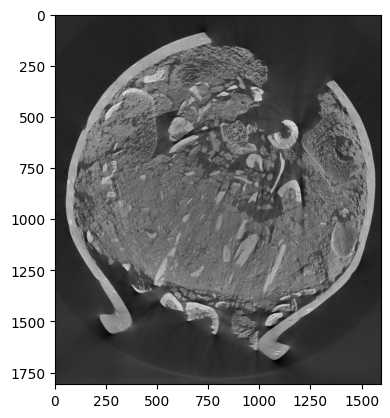

In [34]:
plt.imshow(sl, cmap="gray")
plt.show()

## chargement SAM

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if not Path(SAM_WEIGHTS).exists():
    print(f"Downloading {SAM_WEIGHTS}...")
    model = SAM(SAM_WEIGHTS)
else:
    print(f"{SAM_WEIGHTS} already exists locally")
    model = SAM(SAM_WEIGHTS)

print("SAM chargé")

Device: cuda
../data/sam_b.pt already exists locally
SAM chargé


## INFERENCE PAR CHUNKS DE POINTS


In [36]:
from typing import Union
r = None
def run_sam_chunked_points(model: SAM, image, points: Union[list[tuple[int, int]], int], labels=None,
                           conf=0.35, points_per_call=25, device="cpu", binarize_thr=0.5):
    img = image if image.ndim == 3 else np.dstack([image, image, image])
    # >>>> ???? >>>>
    if img.dtype != np.uint8:
        mn, mx = float(img.min()), float(img.max())
        img = ((img - mn) / (mx - mn) * 255).astype(np.uint8) if mx > mn else np.zeros_like(img, dtype=np.uint8)
    img = np.ascontiguousarray(img)
    # <<<< ???? <<<<
    masks = []
    with torch.inference_mode():
        if isinstance(points, int):
            r = model.predict(source=img, points_stride=points, points_batch_size=points_per_call, conf=conf, device=device)
            if getattr(r, "masks", None) is not None and r.masks is not None:
                t = r.masks.data  # [N,H,W]
                arr = (t > binarize_thr).cpu().numpy()
                masks.extend(mi.astype(bool) for mi in arr)
        else:
            for i in range(0, len(points), points_per_call):
                r = model.predict(source=img,
                                  points=points[i:i+points_per_call],
                                  labels=labels[i:i+points_per_call],
                                  conf=conf, device=device)[0]
                if getattr(r, "masks", None) is not None and r.masks is not None:
                    t = r.masks.data  # [N,H,W]
                    arr = (t > binarize_thr).cpu().numpy()
                    masks.extend(mi.astype(bool) for mi in arr)
        if device == "cuda":
            torch.cuda.empty_cache()
    return masks # non dédupliqués


### grille de points et inférence

In [37]:
type(sl)

numpy.ndarray

In [38]:
tracker = EmissionsTracker()
tracker.start()
H, W = sl.shape[:2]
points, labels = make_grid_points(H, W, GRID_STRIDE, label=POINT_LABEL)
print(f"Points de grille: {len(points)}  (stride={GRID_STRIDE})")

[codecarbon WARNING @ 09:56:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:56:17] [setup] RAM Tracking...
[codecarbon INFO @ 09:56:17] [setup] CPU Tracking...
[codecarbon WARNING @ 09:56:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 09:56:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) W-1270 CPU @ 3.40GHz
[codecarbon WARNING @ 09:56:18] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 09:56:18] [setup] GPU Tracking...
[codecarbon INFO @ 09:56:18] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:56:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 

Points de grille: 700  (stride=64)


In [39]:
raw_masks = run_sam_chunked_points(model, sl, points, labels, conf=CONF_THR,points_per_call=POINTS_PER_CALL, device=device)


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 303.2ms
Speed: 5.6ms preprocess, 303.2ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 301.1ms
Speed: 5.6ms preprocess, 301.1ms inference, 5.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 301.0ms
Speed: 5.7ms preprocess, 301.0ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 

[codecarbon INFO @ 09:56:51] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:56:52] Delta energy consumed for CPU with cpu_load : 0.000032 kWh, power : 8.017911548 W
[codecarbon INFO @ 09:56:52] Energy consumed for All CPU : 0.000067 kWh
[codecarbon INFO @ 09:56:52] Energy consumed for all GPUs : 0.000544 kWh. Total GPU Power : 28.779314005357524 W
[codecarbon INFO @ 09:56:52] 0.000777 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 09:57:51] Energy consumed for RAM : 0.000489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:57:52] Delta energy consumed for CPU with cpu_load : 0.000032 kWh, power : 8.0180731835 W
[codecarbon INFO @ 09:57:52] Energy consumed for All CPU : 0.000196 kWh
[codecarbon INFO @ 09:57:52] Energy consumed for all GPUs : 0.000814 kWh. Total GPU Power : 16.14253576681915 W
[codecarbon INFO @ 09:57:52] 0.001498 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecar

In [40]:
masks = dedup_by_iou(raw_masks, iou_thr=DEDUP_IOU_THR, min_area=MIN_AREA)
print(f" {len(masks)} masques après filtrage & dé-dup")

[codecarbon INFO @ 09:56:36] Energy consumed for RAM : 0.000086 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:56:37] Delta energy consumed for CPU with cpu_load : 0.000035 kWh, power : 8.020394820800002 W
[codecarbon INFO @ 09:56:37] Energy consumed for All CPU : 0.000035 kWh
[codecarbon INFO @ 09:56:37] Energy consumed for all GPUs : 0.000424 kWh. Total GPU Power : 95.31518756127636 W
[codecarbon INFO @ 09:56:37] 0.000545 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 09:57:06] Energy consumed for RAM : 0.000247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 09:57:07] Delta energy consumed for CPU with cpu_load : 0.000032 kWh, power : 8.0181855125 W
[codecarbon INFO @ 09:57:07] Energy consumed for All CPU : 0.000099 kWh
[codecarbon INFO @ 09:57:07] Energy consumed for all GPUs : 0.000611 kWh. Total GPU Power : 16.25403168584458 W
[codecarbon INFO @ 09:57:07] 0.000958 kWh of electricity and 0.000000 L of water were used since the beginning.
[co

 281 masques après filtrage & dé-dup


## SAVE VISUALISATION

[codecarbon INFO @ 10:00:06] Energy consumed for RAM : 0.001213 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:00:07] Delta energy consumed for CPU with cpu_load : 0.000032 kWh, power : 8.0185053545 W
[codecarbon INFO @ 10:00:07] Energy consumed for All CPU : 0.000487 kWh
[codecarbon INFO @ 10:00:07] Energy consumed for all GPUs : 0.001414 kWh. Total GPU Power : 16.01376502407078 W
[codecarbon INFO @ 10:00:07] 0.003114 kWh of electricity and 0.000000 L of water were used since the beginning.


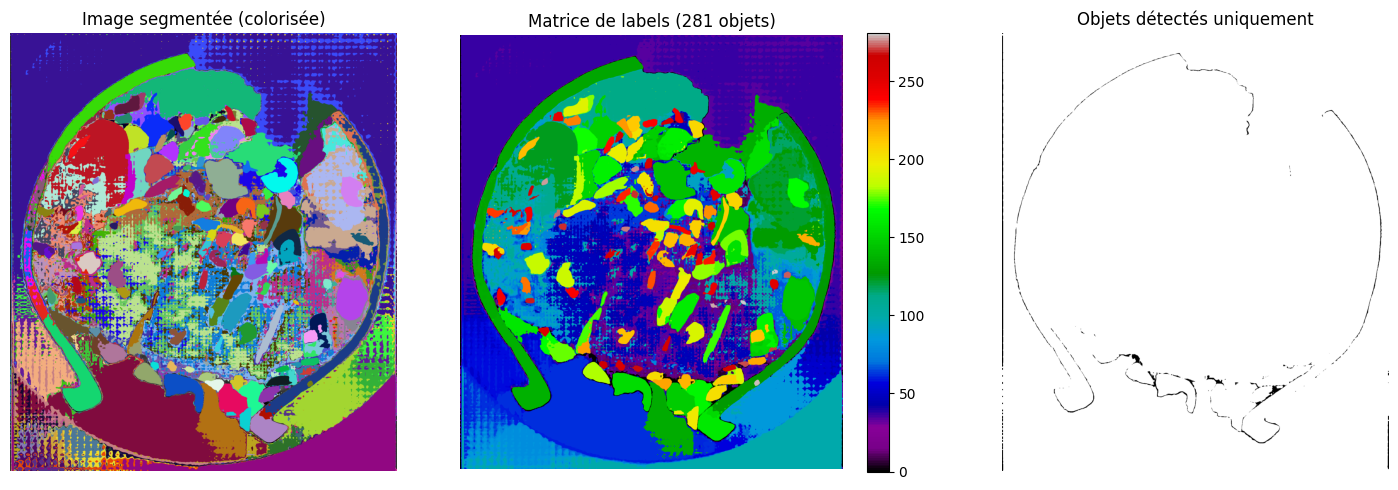


=== Résultats ===
Nombre d'objets: 281
Shape matrice: (1808, 1595)
Labels uniques: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 2

In [41]:
if len(masks) == 0:
    print(" Aucun objet détecté ")
else:
    masks_sorted = sorted(masks, key=lambda x: x.sum(), reverse=True)
    
    # 1. Image colorisée
    colored = colorize_masks(sl, masks_sorted, seed=0)
    
    # 2. Matrice de labels
    label_matrix = create_label_matrix(masks_sorted, sl.shape)
    
    # 3. Image avec seulement les objets
    objects_only = create_objects_only_image(masks_sorted, sl.shape)
    
    # Affichage
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(colored)
    plt.title("Image segmentée (colorisée)")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(label_matrix, cmap='nipy_spectral')
    plt.title(f"Matrice de labels ({label_matrix.max()} objets)")
    plt.colorbar()
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(objects_only, cmap="gray")
    plt.title("Objets détectés uniquement")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    # Informations
    print(f"\n=== Résultats ===")
    print(f"Nombre d'objets: {label_matrix.max()}")
    print(f"Shape matrice: {label_matrix.shape}")
    print(f"Labels uniques: {np.unique(label_matrix)}")
    
    # Tu peux maintenant utiliser:
    # - colored : image colorisée RGB
    # - label_matrix : matrice avec numéros d'objets
    # - objects_only : image originale avec seulement les objets

### WRITE CODECARBONE RESULTS AND STOP TRACKER

In [42]:
emissions= tracker.stop()
with open("emissions.csv", "a", newline="") as f:
    writer = csv.writer(f)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    writer.writerow([timestamp, emissions])


[codecarbon INFO @ 10:00:08] Energy consumed for RAM : 0.001217 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 10:00:08] Delta energy consumed for CPU with cpu_load : 0.000002 kWh, power : 8.006585000000001 W
[codecarbon INFO @ 10:00:08] Energy consumed for All CPU : 0.000488 kWh
[codecarbon INFO @ 10:00:08] Energy consumed for all GPUs : 0.001419 kWh. Total GPU Power : 16.01078911464379 W
[codecarbon INFO @ 10:00:08] 0.003124 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 10:00:08] 0.000668 g.CO2eq/s mean an estimation of 21.078450327870804 kg.CO2eq/year
